# Survival Analysis

이 장에서는 특정 사건이 지속되는 시간에 대해 사용되는 통계적 방법모음, 생존분석에 대해 설명하겠다. 

의약품의 경우 이는 말 그대로 생존이라는 의미가 되지만 어떤 종류의 사건이 지속되는 시간에도 적용할 수 있고 혹은 시간 대신 공간이나 다른 차원에도 적용 가능하다.

우리가 보유한 데이터는 때때로 불완전해서 생존분석을 적용하기 어렵다. 

그러나 곧 살펴보겠지만, 베이지안 방법론은 데이터가 부족한 경우 매우 좋은 선택이다. 

예를 들어, 생사를 다루는 것보다는 다소 가벼운, 전구의 수명과 보호소의 개가 입양될 때까지의 시간에 대한 문제를 푼다고 하자. 

이 '생존 시간'을 나타내는 데는 __와이불분포__ 를 사용할 것이다.

## 14.1 Weibull Distribution

와이불분포는 여러 범위의 제품 수명분포를 나타내는 데 좋은 모델이어서 생존 분석에서도 종종 사용된다. 

scipy에서는 여러 버전의 와이불 분포를 제공하는 데, 여기서 사용할 것은 weibull_min()이다. 

$$f(x;\lambda, k) = \begin{cases}
\frac{k}{\lambda}(\frac{x}{\lambda})^{k-1}e^{-(\frac{x}{\lambda})^{k}} & \text{,} x\geq 0 \\
0 & \text{,} x<0 
\end{cases}$$


- note: lambda 는 scale parameter, k 는 shape parameter 다. 
  - k
    - k 가 1보다 작으면 분포는 감소하는(hazard rate가 감소하는) 형태를 가지고, 수명의 초기 단계에서는 높은 신뢰성을 나타냄
    - k 가 1보다 크면 분포는 증가하는 형태를 가지고 수명의 초기 단계에서는 낮은 신뢰성을 나타냄
    - k 가 1일 경우 지수분포와 동일하며 일정한 hazard rate를 나타냄
  - lambda
    - lambda 가 증가하면 분포가 더 오른쪽으로 이동하며, 시간이나 수명이 증가함
  

사용 기호의 일관성을 맞추기 위해, 위치나 분포의 '중심 경향치'에 가장 영향을 미치는 매개변수 $\lambda$와 모양에 영향을 미치는 매개변수 k를 사용하는 함수 형태로 만들도록 하겠다. 

In [1]:
from scipy.stats import weibull_min

def weibull_dist(lam, k):
    return weibull_min(k, scale = lam)

In [2]:
lam = 3
k = 0.8
actual_dist = weibull_dist(lam,k)

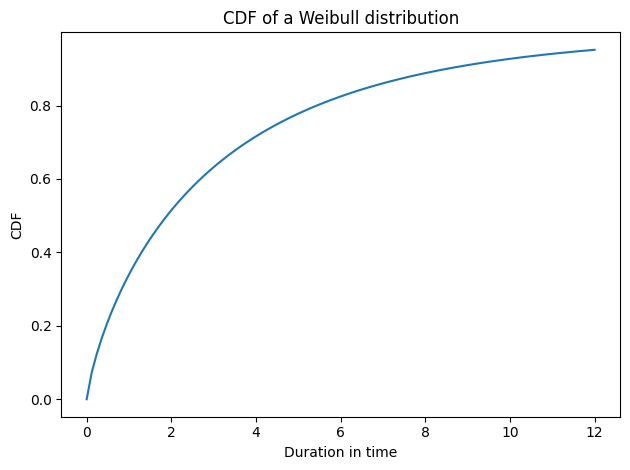

In [3]:
import numpy as np
from empiricaldist import Cdf
from utils import decorate

qs = np.linspace(0, 12, 101)
ps = actual_dist.cdf(qs)
cdf = Cdf(ps, qs)
cdf.plot()

decorate(xlabel='Duration in time', 
         ylabel='CDF',
         title='CDF of a Weibull distribution')

actual_dist 에는 이 분포에서 임의의 표본을 만드는 rvs()가 있다.

In [4]:
data = actual_dist.rvs(10)  # random variable sample
data

array([0.32787988, 0.81237093, 1.46165393, 2.99215282, 0.20714301,
       1.30538394, 2.49335067, 0.02845345, 2.63575713, 3.16045584])

이런 식으로 분포의 매개변수가 주어지면 표본을 만들 수 있다. 

그러면 다른 방향으로 표본이 있을 때 매개변수를 추정하는 법을 알아보자.

다음은 $\lambda$에 대한 사전균등분포와 k에 대한 사전균등분포다. 

In [5]:
from utils import make_uniform

lams = np.linspace(0.1, 10.1, num = 101)
prior_lam = make_uniform(lams, name = 'lambda')
prior_lam

,probs
lambda,
0.1,0.009901
0.2,0.009901
0.3,0.009901
0.4,0.009901
0.5,0.009901
...,...
9.7,0.009901
9.8,0.009901
9.9,0.009901


In [6]:
ks = np.linspace(0.1, 5.1, 101)
prior_k = make_uniform(ks, name = 'k')
prior_k

,probs
k,
0.10,0.009901
0.15,0.009901
0.20,0.009901
0.25,0.009901
0.30,0.009901
...,...
4.90,0.009901
4.95,0.009901
5.00,0.009901


이제 make_joint()를 사용해서 두 매개변수에 대한 사전결합분포를 구해보자. 

note: 결합분포를 만드는 방법은, np.meshgrid 메서드를 사용하여 s1,s2로 가능한 모든 조합을 만든 후 곱하는 것.

```python
def make_joint(s1, s2):
    """Compute the outer product of two Series.

    First Series goes across the columns;
    second goes down the rows.

    s1: Series
    s2: Series

    return: DataFrame
    """
    X, Y = np.meshgrid(s1, s2)
    return pd.DataFrame(X*Y, columns=s1.index, index=s2.index)
```

In [7]:
from utils import make_joint

prior = make_joint(prior_lam, prior_k)
prior

lambda,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,...,9.2,9.3,9.4,9.5,9.6,9.7,9.8,9.9,10.0,10.1
k,,,,,,,,,,,,,,,,,,,,,
0.10,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098
0.15,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098
0.20,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098
0.25,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098
0.30,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.90,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098
4.95,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098
5.00,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098


결과는 열에 lambda의 가능한 값이 나열되고 k의 가능한 값이 행에 나열되는 데이터프레임 형식이다. 

여기에 meshgrid()를 적용해서 첫 축(axis =0)에 람다를, 두 번째 축(axis=1)에 k를, 세 번째 축(axis=2)에 데이터를 넣은 3차원 메쉬를 만들자. 

note: data 는 맨처음에 만들었던 lam = 3, k = 0.8 인 와이불 분포에서 나온 10 개의 랜덤샘플이다.

In [8]:
lam_mesh, k_mesh, data_mesh = np.meshgrid(
    prior.columns, prior.index, data
)

그럼 이제 weibull_dist()를 사용해서 각 매개변수의 쌍과 데이터값을 이용해 와이불분포의 PDF를 구할 수 있다.

In [9]:
densities = weibull_dist(lam_mesh, k_mesh).pdf(data_mesh)

데이터의 likelihood 는 axis = 2 의 확률밀도의 외적이다.

In [10]:
likelihood = densities.prod(axis=2)
likelihood

array([[1.69089392e-14, 1.95276389e-14, 2.06935891e-14, ...,
        1.70830903e-14, 1.70469257e-14, 1.70110628e-14],
       [5.89975194e-13, 8.36981229e-13, 9.62822798e-13, ...,
        6.61982254e-13, 6.59051933e-13, 6.56153188e-13],
       [4.89076816e-12, 9.57564321e-12, 1.25085771e-11, ...,
        7.05760327e-12, 7.00581617e-12, 6.95474351e-12],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.92243667e-46, 1.16355921e-46, 7.07760338e-47],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        6.20807305e-47, 3.73853938e-47, 2.26271859e-47],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.00273246e-47, 1.19998886e-47, 7.22665084e-48]])

이제 일반적인 방식으로 사후분포를 구할 수 있다. 

다음 함수는 지금까지 했던 과정을 하나로 묶은 것이다. 이 함수는 사전결합분포와 데이터를 사용해서 사후결합분포를 반환한다.

In [11]:
from empiricaldist import Pmf
from utils import normalize

def update_weibull(prior, data):
    """Update the prior based on data."""
    lam_mesh, k_mesh, data_mesh = np.meshgrid(
        prior.columns, prior.index, data)
    
    densities = weibull_dist(lam_mesh, k_mesh).pdf(data_mesh)
    likelihood = densities.prod(axis=2)

    posterior = prior * likelihood
    normalize(posterior)

    return posterior

In [12]:
posterior = update_weibull(prior, data)

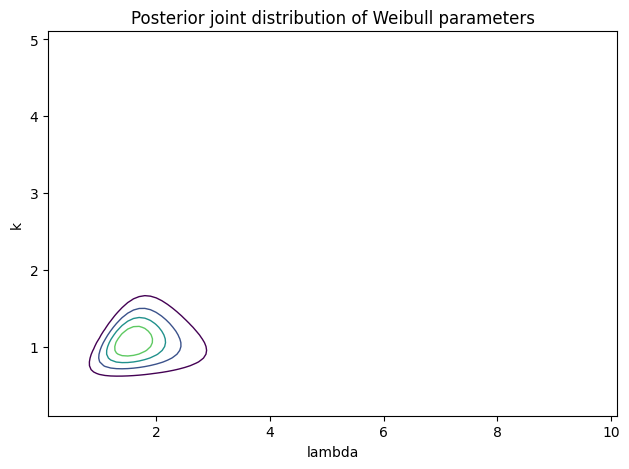

In [13]:
from utils import plot_contour

plot_contour(posterior)
decorate(title='Posterior joint distribution of Weibull parameters')

### Marginal distributions

In [14]:
from utils import marginal

posterior_lam = marginal(posterior, 0)
posterior_k = marginal(posterior, 1)

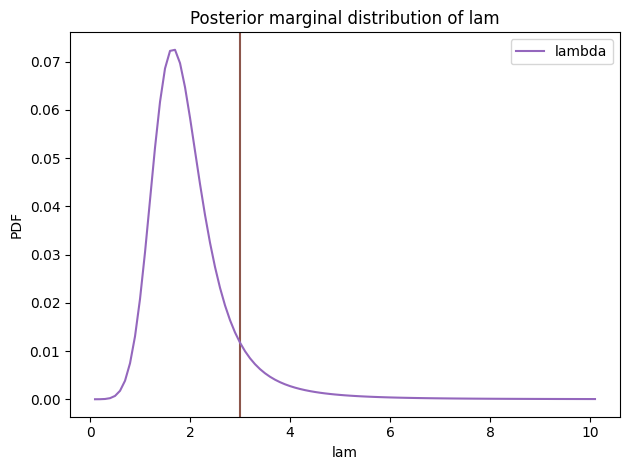

In [15]:
import matplotlib.pyplot as plt

plt.axvline(3, color='C5')
posterior_lam.plot(color='C4', label='lambda')
decorate(xlabel='lam',
         ylabel='PDF', 
         title='Posterior marginal distribution of lam')

The vertical gray line show the actual value of $\lambda$.

Here’s the marginal posterior distribution for $k$.

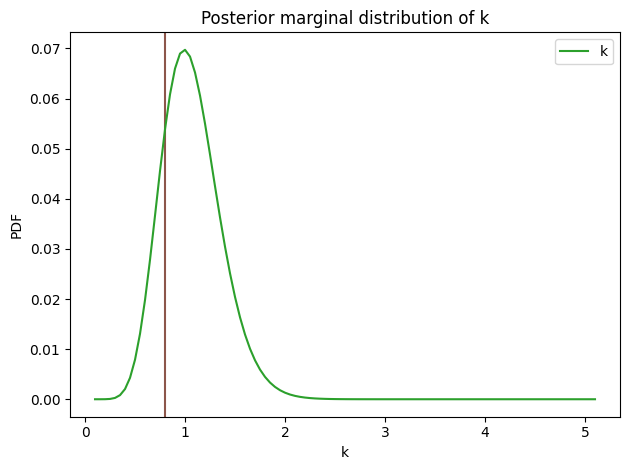

In [16]:
plt.axvline(0.8, color='C5')
posterior_k.plot(color='C12', label='k')
decorate(xlabel='k',
         ylabel='PDF', 
         title='Posterior marginal distribution of k')

The posterior distributions are wide, which means that with only 10 data points we can’t estimated the parameters precisely. 

But for both parameters, the actual value falls in the credible interval.

In [17]:
print(lam, posterior_lam.credible_interval(0.9))

3 [1.1 3.4]


In [18]:
print(k, posterior_k.credible_interval(0.9))

0.8 [0.65 1.6 ]


## 14.2 Incomplete data

앞에서 와이불분포에서 10개의 임의의 값을 가져와서 이를 사용해 매개변수를 (마치 몰랐던 양) 추정했다.

하지만 많은 실제 상황의 경우 데이터가 완전하지 않을 수 있다. 특히 특정 시간에 시스템을 관찰하는 경우 과거의 정보는 남아있지만 미래에 대한 정보는 전혀 없다.

예를 들어, 유기견 보호소에서 일하면서 유기견이 들어온 후 입양되는 데까지 걸리는 시간에 관심을 가지게 되었다고 하자. 

어떤 개는 오자마자 바로 입양자가 나타날 수도 있고, 어떤 개는 오래 기다릴 수도 있다. 

보호소를 운영하는 사람들은 개들을 임시보호하는 시간을 추론할 수 있으면 좋을 것이다. 

유기견 보호소에서 8주 동안 10마리의 개가 들어왔다가 입양되는 것을 살펴보았다고 하자. 개가 들어오는 시간은 균등분포를 따른다고 가정하면 다음과 같이 임의의 값을 생성할 수 있다.

In [19]:
start = np.random.uniform(0,8, size=10)
start

array([7.39714847, 6.49081072, 7.60019144, 3.34566746, 4.24092268,
       5.7272583 , 3.53173417, 0.39680055, 0.1615107 , 7.07171303])

그럼 임시보호 시간은 앞에서 사용했던 와이불분포를 따른다고 하자. 그럼 이 분포에서 다음과 같은 표본을 만들어낼 수 있다.

In [20]:
duration = actual_dist.rvs(10) # lambda = 3, k = 1
duration

array([2.15130969, 2.50911832, 1.07294214, 0.02207043, 5.18238949,
       0.51706349, 6.85518113, 1.30211101, 2.78517907, 7.21144118])

이 값을 사용해서 각 개가 들어오고 나가는 시간에 대한 데이터프레임을 만들 것이다. 이 데이터프레임을 각각 start 와 end라고 하자. 

그리고 화면에 출력하기 위해 데이터프레임을 들어오는 시간 순서대로 정렬해보자.

In [21]:
import pandas as pd

d = dict(start = start, end = start + duration)
obs = pd.DataFrame(d).sort_values(by = 'start', ignore_index=True)
obs

,start,end
0,0.161511,2.946690
1,0.396801,1.698912
2,3.345667,3.367738
3,3.531734,10.386915
4,4.240923,9.423312
5,5.727258,6.244322
6,6.490811,8.999929
7,7.071713,14.283154
8,7.397148,9.548458
9,7.600191,8.673134


몇몇 end 시점이 관측 window인 8주를 초과한 시점임을 확인할 수 있다. 이 경우 이 시스템을 8주 시작지점에서 본다면 일부 정보는 불완전한 상태이다. 

개 5, 7, 8 번의 경우 입양시점을 알 수 없다. 

관측기간을 넘기는 생존시간선을 구분하여 이 불완전한 데이터를 시뮬레이션해보자.

In [22]:
censored = obs['end'] > 8

censored 는 생존시간선이 8주를 넘기는 경우 True라고 표시되는 불리언시리즈다. 

사용할 수 없는 데이터는 우리에게 숨겨져 있다는 의미에서 censored라고 한다. 

제한된 생존시간선의 end는 최종관측된 시점의 값으로 변경하고, status에는 관측값이 불완전하다는 것을 표기한다.

In [23]:
obs.loc[censored, 'end'] = 8
obs.loc[censored, 'status'] = 0

그러면 이제 각 개에 대한 생존시간선을 그려서 시간에 따른 보호소 도착 시간과 입양 시간을 나타낼 수 있다.

In [24]:
import matplotlib.pyplot as plt

def plot_lifelines(obs):
    """Plot a line for each observation.
    
    obs: DataFrame
    """
    for y, row in obs.iterrows():
        start = row['start']
        end = row['end']
        status = row['status']
        
        if status == 0:
            # ongoing
            plt.hlines(y, start, end, color='C0')
        else:
            # complete
            plt.hlines(y, start, end, color='C1')
            plt.plot(end, y, marker='o', color='C1')
            
    decorate(xlabel='Time (weeks)',
             ylabel='Dog index',
             title='Lifelines showing censored and uncensored observations')

    plt.gca().invert_yaxis()

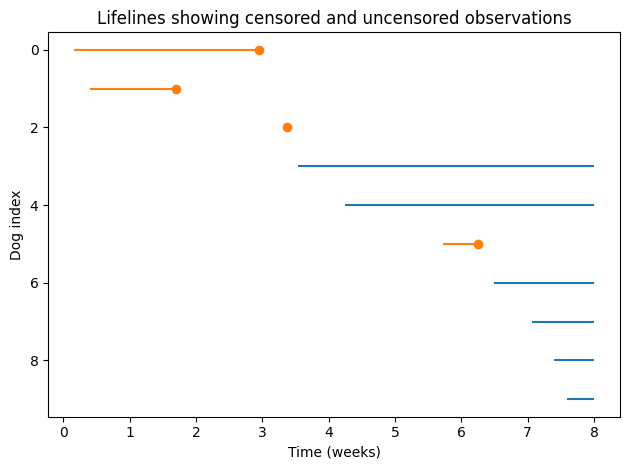

In [25]:
plot_lifelines(obs)

데이터 테이블에 생존시간선의 기간에 대한 열을 추가하자. 이렇게 시뮬레이션한 데이터는 8주차 초반에 사용할 수 있다.

In [26]:
obs['T'] = obs['end'] - obs['start']

## 14.3 Use Incomplete data

그럼 완전한 데이터와 불완전한 데이터 모두를 사용해서 임시보호 시간의 분포에 대한 모수를 추정해보자.

일단 데이터를 두 개의 집합으로 나눌 것이다. data1에는 도착 및 입양 시점을 모두 아는 개의 임시보호 시간을 기록하고, data2 에는 관측 기간 동안에는 입양되지 않은 개의 불완전한 임시보호기간을 기록한다.

완전한 데이터의 경우, update_weibull()을 사용해서 와이불분포의 PDF로 데이터의 가능도를 구할 수 있다. 

In [27]:
data1 = obs.loc[~censored, 'T']
data2 = obs.loc[censored, 'T']

In [28]:
posterior1 = update_weibull(prior, data1) # prior = joint uniform distribution of uniform lambda, uniform k

불완젆난 경우에는 좀 더 어렵다. 관측이 끝나는 시점에서 보호가 얼마나 더 지속될지 알 수 없다. 

하지만 보호 시간의 최소한도를 정해두면 보호 시간이 T보다는 클 것이라고 말할 수 있다.

즉 분포의 값이 T를 초과할 확률을 구하는 생존함수를 사용하여 데이터의 가능도를 구할 수 있다. 

다음 함수는 update weilbull 과 동일하지만 여기서는 pdf 대신 생존함수 sf 를 사용한다.

In [29]:
def update_weibull_incomplete(prior, data):
    """Update the prior using incomplete data."""
    lam_mesh, k_mesh, data_mesh = np.meshgrid(
        prior.columns, prior.index, data)
    
    # evaluate the survival function
    probs = weibull_dist(lam_mesh, k_mesh).sf(data_mesh)
    likelihood = probs.prod(axis=2)

    posterior = prior * likelihood
    normalize(posterior)

    return posterior

In [30]:
posterior2 = update_weibull_incomplete(posterior1, data2)

두 갱신을 거친 후 결합분포는 다음과 같다.

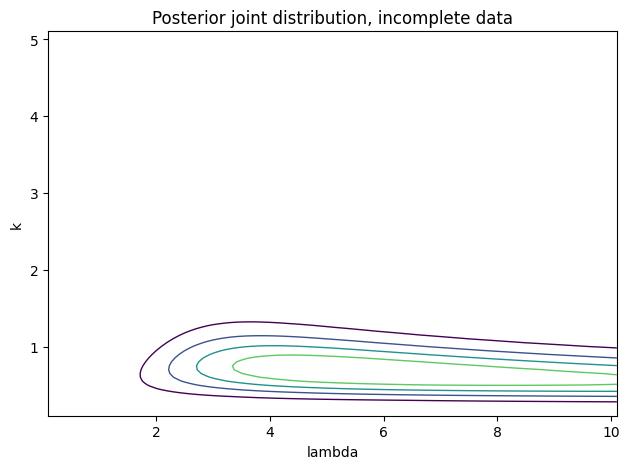

In [31]:
plot_contour(posterior2)
decorate(title='Posterior joint distribution, incomplete data')

이전 등고선 그래프와 비교했을 때, 가능한 람다의 값의 범위가 상대적으로 넓어진 것으로 보인다. 

주변분포를 살펴보면 보다 명확히 확인할 수 있다.

In [32]:
from utils import marginal

posterior_lam2 = marginal(posterior2, 0)
posterior_k2 = marginal(posterior2, 1)

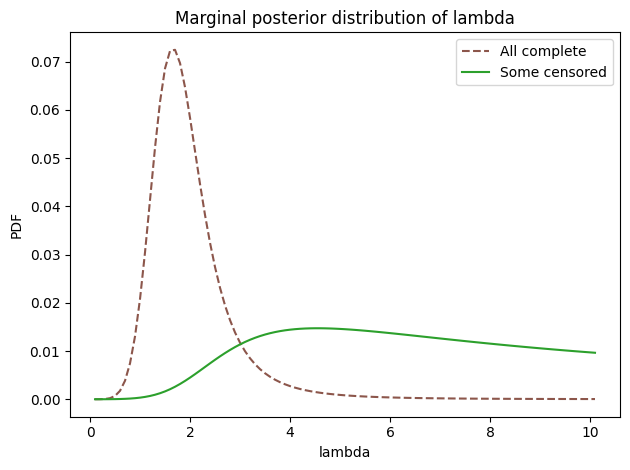

In [33]:
posterior_lam.plot(color='C5', label='All complete',
                   linestyle='dashed')
posterior_lam2.plot(color='C2', label='Some censored')

decorate(xlabel='lambda',
         ylabel='PDF', 
         title='Marginal posterior distribution of lambda')

불완전 데이터를 포함한 분포가 상대적으로 폭이 넓다.

여담으로, 사후분포의 경우 아무리 오른쪽으로 가도 0이 되는 경우는 없다는 점을 주의하자. 

따라서 사전분포의 범위는 이 매개변수에 대해 모든 가능한 값들을 포함할만큼 충분히 넓지 않다. 

이 분포를 보다 정확하게 만들고 싶다면 사전분포를 보다 넓게 설정한 후 갱신을 하면 된다.

다음은 k의 사후주변분포다.

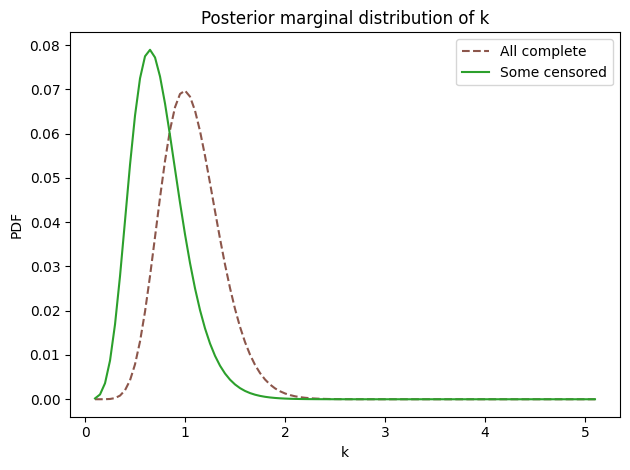

In [34]:
posterior_k.plot(color='C5', label='All complete',
                   linestyle='dashed')
posterior_k2.plot(color='C12', label='Some censored')

decorate(xlabel='k',
         ylabel='PDF', 
         title='Posterior marginal distribution of k')

이 예에서는 불완전한 데이터가 있을 때 주변 분포가 왼쪽으로 이동하지만, 그 폭이 크게 넓어지지는 않는다.

지금까지 완전한 데이터와 불완전한 데이터를 결합하여 와이블 분포의 매개변수를 추정하는 방법을 살펴봤는데, 이는 일부 데이터가 검열되는 많은 실제 시나리오에서 유용하다.

일반적으로 데이터가 불완전할수록, 정보가 적을수록 불확실성이 커지기 때문에 사후 분포가 더 넓어진다.

이 예는 생성한 데이터를 기반으로 한 것이지만, 다음 섹션에서는 실제 데이터로 비슷한 분석을 해보겠다.